In [3]:
import pandas as pd

In [4]:
import sys
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import itertools

sys.path.append('../')

from sys_utils import load_model
from data_model_region import Region
from data_model import RawIndividual
import typing as t
import random
from tqdm import tqdm

In [5]:
checkpoint_path = '../checkpoints_dev'

In [6]:
individuals = load_model(
        RawIndividual, name=checkpoint_path + "/raw_individuals.jsonl"
    )

In [7]:
individuals_filtered = [x for x in individuals if x.raw_nationalities != None]

In [259]:
df_individuals = [
    {
        "wikidata_id": x.wikidata_id,
        "name": x.name,
        "year": x.birthyear,
        "occupation":[y.name for y in x.occupations],
        "category":[y.category for y in x.occupations],
        "nationality":[y.name for y in x.raw_nationalities]
    }
    for x in individuals_filtered
]


In [260]:
df_individuals = pd.DataFrame(df_individuals)
df_individuals = df_individuals.dropna()

In [262]:
def flatten(lst):
    if not isinstance(lst, list):
        return [lst]
    else:
        result = []
        for item in lst:
            result += flatten(item)
        return result

In [265]:
from tqdm import tqdm
tqdm.pandas()

In [266]:
df_individuals['category'] = df_individuals['category'].progress_apply(lambda x : flatten(x))

100%|█████████████████████████████████████████████████| 1243350/1243350 [00:07<00:00, 156167.05it/s]


In [275]:
def get_science(list):
    if 'science' in list:
        return 1
    else:
        return 0

In [277]:
df_individuals['science'] = df_individuals['category'].progress_apply(lambda x : get_science(x))

100%|█████████████████████████████████████████████████| 1243350/1243350 [00:03<00:00, 337707.80it/s]


In [279]:
df_individuals = df_individuals[df_individuals['science']==1]

In [282]:
df = df_individuals.explode('nationality')

In [526]:
df_fra = df[df['nationality']=='France']
df_fra = df_fra.explode('occupation')

In [527]:
df_before = df_fra[df_fra['year']<=1850].reset_index(drop=True)
df_after = df_fra[df_fra['year']>1850].reset_index(drop=True)

In [528]:
top_occupations = df_before['occupation'].value_counts().reset_index()[:50]
top_occupations = list(top_occupations['index'])
df_before = df_before[df_before['occupation'].isin(top_occupations)]
df_before.groupby('wikidata_id')['occupation'].count().mean()

1.738319806975214

In [529]:
top_occupations = df_after['occupation'].value_counts().reset_index()[:50]
top_occupations = list(top_occupations['index'])
df_after = df_after[df_after['occupation'].isin(top_occupations)]
df_after.groupby('wikidata_id')['occupation'].count().mean()

1.4845296385040108

In [530]:
df_before.groupby('occupation')['wikidata_id'].count().reset_index().sort_values('wikidata_id', ascending=False)

,occupation,wikidata_id
8,botanist,817
15,explorer,527
24,mathematician,463
3,archaeologist,448
10,chemist,342
40,physicist,288
31,naturalist,288
18,historian,257
6,astronomer,232
48,university teacher,230


In [782]:
import numpy as np

#define function to calculate Gini coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [783]:
test = df_before.groupby('occupation')['wikidata_id'].count().reset_index().sort_values('wikidata_id', ascending=False)
test = np.array(test.wikidata_id)

In [784]:
gini_coefficient = gini(test)
gini_coefficient

0.4421072555205047

In [785]:
# la repartion des individuds est de plus inégalitaire

In [786]:
# gini coefficient

In [788]:
from scipy.stats import pearsonr

def get_stars(p):
    if  p<0.05:
        return '*'
    elif  p<0.01:
         return '**'
    elif  p<0.001:
        return '***'
    else:
        return ""

In [832]:
df_fra_modern = df_fra[(df_fra['year']>= 1800)&(df_fra['year']<= 1980)].reset_index(drop=True)
df_fra_modern['decade'] = df_fra_modern['year'].apply(lambda x : round(x / 10) * 10)

In [833]:

df_count_pop = df_fra_modern[['year', 'wikidata_id']].drop_duplicates()
df_count_pop['decade'] =  df_count_pop['year'].apply(lambda x : round(x / 10) * 10)
df_count_pop = df_count_pop.groupby('decade')['wikidata_id'].count().reset_index()
#df_count_pop = df_count_pop[df_count_pop['wikidata_id']>=100]

In [834]:
#random_people = df_fra_modern[['wikidata_id', 'decade']].drop_duplicates()
#random_people = random_people.groupby('decade')['wikidata_id'].sample(50).reset_index()
#random_people = list(random_people['wikidata_id'])

In [835]:
#df_fra_modern.groupby(['decade', 'occupation'])['wikidata_id'].value_counts(normalize = True).

In [836]:
#df_fra_modern = df_fra_modern[df_fra_modern['wikidata_id'].isin(random_people)]

df_fra_modern = df_fra_modern.groupby(['decade', 'occupation'])['wikidata_id'].count().reset_index()
df_fra_modern = df_fra_modern.sort_values(['decade', 'wikidata_id'], ascending=(False, False))


In [838]:


df_fra_modern = df_fra_modern.groupby('decade').head(20).reset_index(drop=True)
df_fra_modern = df_fra_modern[~df_fra_modern['occupation'].isin(['university teacher'])]


In [839]:

df_count = df_fra_modern.groupby('decade')['wikidata_id'].sum().reset_index()
df_count.columns = ['decade', 'total_decade']

df_fra_modern = pd.merge(df_fra_modern, df_count, on = 'decade')

In [840]:
df_fra_modern['percent'] = df_fra_modern['wikidata_id']/df_fra_modern['total_decade']

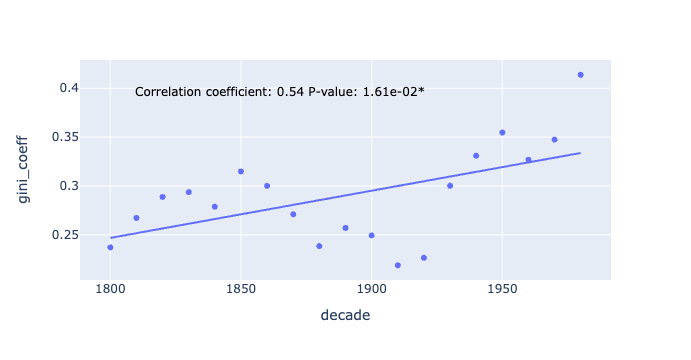

In [843]:
df_fra_modern = df_fra_modern.groupby('decade')['percent'].apply(np.array).reset_index()
df_fra_modern['gini_coeff'] = df_fra_modern['percent'].apply(lambda x : gini(x))

fig = px.scatter(df_fra_modern, x = 'decade', y= 'gini_coeff', trendline="ols")

corr_coef, p_value =  pearsonr(df_fra_modern['decade'], df_fra_modern['gini_coeff'])

# Add text annotation for correlation coefficient and p-value
fig.add_annotation(
    x=0.1, y=0.9,
    text=f'Correlation coefficient: {corr_coef:.2f}\nP-value: {p_value:.2e}{get_stars(p_value)}',
    showarrow=False,
    xref='paper', yref='paper',
    font=dict(size=12, color='black'),
)

# Show plot
fig.show()

In [740]:
df_stats = df_fra_modern.copy()
df_stats = pd.merge(df_stats, df_count_pop.rename(columns = {'wikidata_id':'pop'}), on = 'decade')
df_stats = df_stats[['decade', 'gini_coeff', 'pop']]


# set the decade column as the index
df_stats = df_stats.set_index('decade')

# create a new index with yearly values
yearly_index = pd.Index(range(df_stats.index.min(), df_stats.index.max() + 1), name='decade')

# reindex the DataFrame with the yearly index and interpolate the missing values
interpolated_df = df_stats.reindex(yearly_index).interpolate(method='linear')

# print the interpolated DataFrame
interpolated_df = interpolated_df.reset_index()
interpolated_df['nationality'] = 'France'
interpolated_df = interpolated_df.rename(columns = {'decade':'year'})

final_stats = pd.merge(interpolated_df, df_maddison_filtered, on = ['year', 'nationality'])
final_stats = final_stats.sort_values('year')

In [756]:
df_stats_new  = df_stats.reset_index()
df_stats_new['nationality'] = 'France'
df_stats_new = df_stats_new.rename(columns = {'decade':'year'})

df_stats_new =  pd.merge(df_stats_new, df_maddison_filtered, on = ['year', 'nationality'])

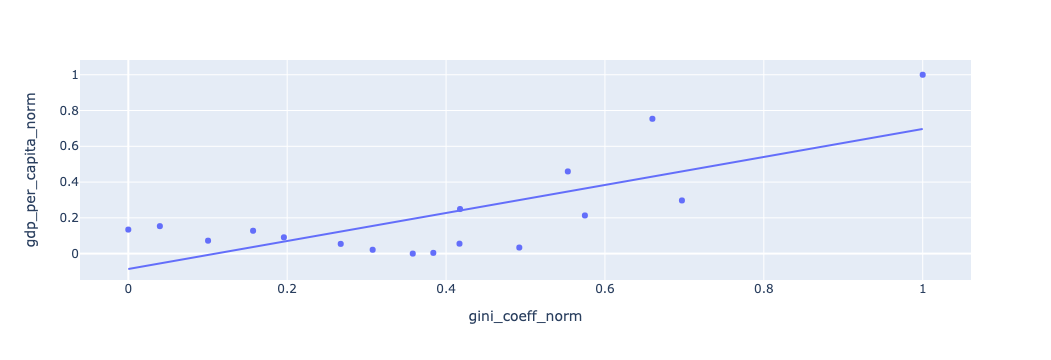

In [760]:
min_max_scaler = preprocessing.MinMaxScaler()
df_stats_new['gini_coeff_norm'] =  min_max_scaler.fit_transform(df_stats_new[['gini_coeff']])
df_stats_new['gdp_per_capita_norm'] =  min_max_scaler.fit_transform(df_stats_new[['gdp_per_capita']])
px.scatter(df_stats_new, x = 'gini_coeff_norm', y = 'gdp_per_capita_norm', trendline = 'ols')

In [761]:
import statsmodels.formula.api as smf

# load the data into a DataFrame

# perform a multiple regression analysis with 'country' as a control variable
model = smf.ols('gini_coeff_norm ~ gdp_per_capita_norm + pop + year', data=df_stats_new)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        gini_coeff_norm   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     19.78
Date:                Sun, 26 Mar 2023   Prob (F-statistic):           3.98e-05
Time:                        20:20:28   Log-Likelihood:                 13.855
No. Observations:                  17   AIC:                            -19.71
Df Residuals:                      13   BIC:                            -16.38
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              12.5883    

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=17



In [12]:
df_filtered = df[df['nationality'].isin(['Germany', 'Spain', 'France', 'Italy', 'United States of America'])]
df_filtered = df_filtered.groupby(['year', 'nationality'])['wikidata_id'].count().reset_index()

In [13]:
df_filtered['impact_year'] = df_filtered['year'] + 35
df_fig = df_filtered[(df_filtered['year']>= 1900)&(df_filtered['year']<= 2020)]

In [14]:
import plotly.express as px

In [15]:
fig = px.line(df_fig, x = 'year', y ='wikidata_id', color = 'nationality')

In [16]:
from functions_environment import get_maddison_data

data_path_environment = "../data_env"
df_maddison = get_maddison_data(data_path_environment)

In [56]:
df_maddison_filtered = df_maddison[df_maddison['country_code_maddison'].isin(['ESP', 'ITA', 'FRA', 'DNK', 'JPN'])]

In [58]:
dict_countries = {'ESP':'Spain', 'ITA':'Italy', 'DNK':'Denmark', 'JPN':'Japan', 'FRA':'France'}

In [59]:
df_maddison_filtered['nationality'] = df_maddison_filtered['country_code_maddison'].apply(lambda x : dict_countries.get(x))
df_maddison_filtered = df_maddison_filtered[['year', 'gdp_per_capita', 'nationality']]

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_51086/2932998962.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [115]:
df_cultural = df[df['nationality'].isin(['Spain', 'Italy', 'France', 'Denmark', 'Japan'])]
df_cultural = df_cultural.groupby(['year', 'nationality'])['wikidata_id'].count().reset_index()

In [116]:
final = pd.merge(df_cultural, df_maddison_filtered, on = ['nationality', 'year'])
final['year'] = final['year'] + 30
final = final[final['year']<=1980]


In [123]:
min_max_scaler = preprocessing.MinMaxScaler()

final['wikidata_id_norm'] = min_max_scaler.fit_transform(final[['wikidata_id']])
final['gdp_per_capita_norm'] = min_max_scaler.fit_transform(final[['gdp_per_capita']])



#final['wikidata_id_norm'] =final[['wikidata_id']]
#final['gdp_per_capita_norm'] = final[['gdp_per_capita']]


In [124]:
import pandas as pd
import statsmodels.formula.api as smf

# load the data into a DataFrame


# perform a multiple regression analysis with 'country' as a control variable
model = smf.ols('wikidata_id_norm ~ gdp_per_capita_norm + nationality + year', data=final)
results = model.fit()


In [125]:
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:       wikidata_id_norm   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     447.9
Date:                Sun, 26 Mar 2023   Prob (F-statistic):          4.65e-320
Time:                        16:43:05   Log-Likelihood:                 1504.0
No. Observations:                1392   AIC:                            -2994.
Df Residuals:                    1385   BIC:                            -2957.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.74

In [19]:
df_fra = df_maddison[df_maddison['country_code_maddison']=='ESP']

In [20]:
df_cul = df[df['nationality'].isin(['Spain'])]
df_cul = df_cul.groupby(['year'])['wikidata_id'].count().reset_index()

In [23]:
from sklearn import preprocessing

In [24]:
from scipy.stats import pearsonr

In [109]:
final = []

for x in np.arange(1, 30, 1):


    df_test = pd.merge(df_cul, df_fra, on = 'year')
    
    df_test['year'] = df_test['year'] + x

    df_test = df_test[(df_test['year']>=1800)&(df_test['year']<=1980)]
    
    min_max_scaler = preprocessing.MinMaxScaler()
    
    df_test['wikidata_id_norm'] = df_test['wikidata_id']
    df_test['gdp_per_capita_norm'] = df_test['gdp_per_capita']

    #df_test['wikidata_id_norm'] = min_max_scaler.fit_transform(df_test[['wikidata_id']])
    #df_test['gdp_per_capita_norm'] = min_max_scaler.fit_transform(df_test[['gdp_per_capita']])
    
    df_test = df_test.set_index('year')
    df_fig = df_test[['wikidata_id_norm', 'gdp_per_capita_norm']].unstack().reset_index()
    df_fig.columns =['var', 'impact_year', 'value']


    
    # compute the Pearson correlation coefficient and p-value
    corr, pval = pearsonr(df_test['wikidata_id_norm'], df_test['gdp_per_capita_norm'])
    final.append({'lag':x, "corr":corr, "pval":pval, "df_fig":df_fig})


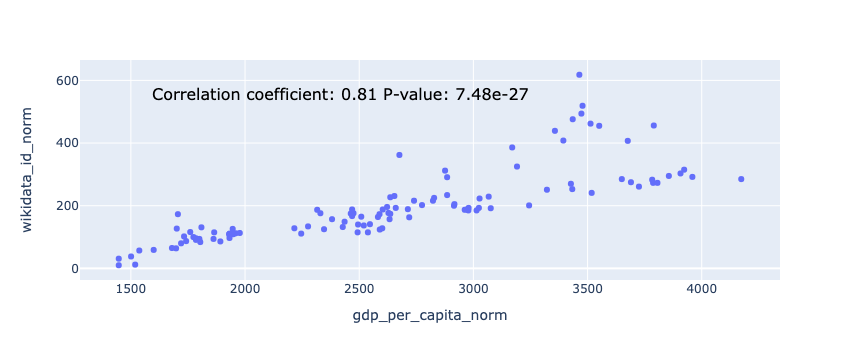

In [110]:
fig = px.scatter(df_test, x = 'gdp_per_capita_norm', y = 'wikidata_id_norm')

corr_coef, p_value =  pearsonr(df_test['wikidata_id_norm'], df_test['gdp_per_capita_norm'])

# Add text annotation for correlation coefficient and p-value
fig.add_annotation(
    x=0.1, y=0.9,
    text=f'Correlation coefficient: {corr_coef:.2f}\nP-value: {p_value:.2e}',
    showarrow=False,
    xref='paper', yref='paper',
    font=dict(size=16, color='black'),
)

# Show plot
fig.show()




In [111]:
df_final = pd.DataFrame(final)
df_final = df_final.sort_values('corr', ascending=False).head(40)

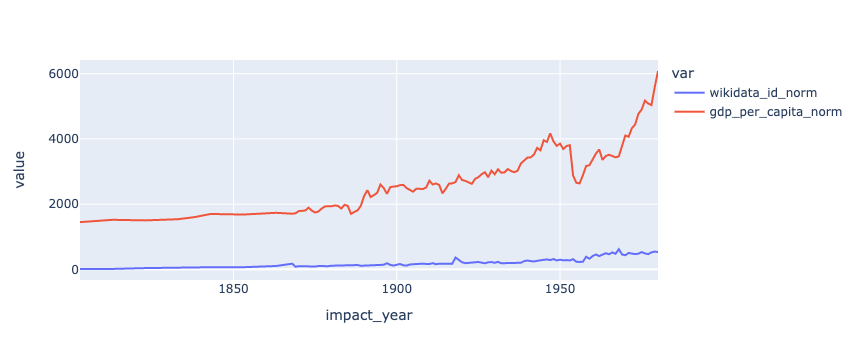

In [112]:
final_fig = df_final['df_fig'].iloc[0]
px.line(final_fig, x = 'impact_year', y = 'value', color = 'var')

In [114]:
df_final = pd.DataFrame(final)

In [ ]:
df_final.sort_values('corr', ascending=False).head(20)

In [ ]:
max(pd.DataFrame(final)['corr'])

In [ ]:
np.arange(1, 100, 1)

In [ ]:

df_test['impact_year'] = df_test['year'] + 35

df_fig = df_test[(df_test['impact_year']>= 1900)&(df_test['impact_year']<= 1950)].reset_index(drop=True)

min_max_scaler = preprocessing.MinMaxScaler()

df_fig['wikidata_id_norm'] = min_max_scaler.fit_transform(df_fig[['wikidata_id']])
df_fig['gdp_per_capita_norm'] = min_max_scaler.fit_transform(df_fig[['gdp_per_capita']])

In [ ]:
df_fig_2 = df_fig[['impact_year', 'wikidata_id_norm', 'gdp_per_capita_norm']].copy()
df_fig_2 = df_fig_2.set_index('impact_year')

In [ ]:
df_fig_2 = df_fig_2[['wikidata_id_norm', 'gdp_per_capita_norm']].unstack().reset_index()
df_fig_2.columns =['var', 'impact_year', 'value']


In [ ]:
fig = px.line(df_fig_2, x = 'impact_year', y = 'value', color = 'var')

In [ ]:
fig